### Imports

In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import shapefile
import geopandas
#import rbf as RBF
import warnings
os.environ["CHOLMOD_USE_GPU"] = "1"
warnings.filterwarnings('ignore')
#%matplotlib inline
# %load_ext snakeviz
%load_ext cython

In [2]:
from FME.geological_points import IePoint, IPoint, GPoint, TPoint
from FME.geological_interpolator import GeologicalInterpolator
from FME.tet_mesh import TetMesh
from FME.dsi_interpolator import DSI
from FME.foldframe import FoldFrame
from FME.fold import FoldEvent, DSIFoldConstraint
#from FME.structural_frame import StructuralFrame
from FME.fault_segment import FaultSegment
from FME.region_manager import RegionManager
from FME.helper import *
from FME.svariogram import s_variogram#

### Load data and build mesh

In [3]:
points = geopandas.read_file('Structural_data.shp')#.gpkg',layer='points')
# orientations = geopandsas.read_file('data.gpkg',layer='orientations')
# model_area = geopanda.read_file('data.gpkg',layer='bounding_box')


In [4]:
x = []
y = []
for p in points['geometry']:
    x.append(p.xy[0][0])
    y.append(p.xy[1][0])#,'bo')
xvar= np.max(x)-np.min(x)
yvar= np.max(y)-np.min(y)

xmin = np.min(x)-0.2*xvar
ymin = np.min(y)-0.2*yvar
xmax = np.max(x)+0.2*xvar
ymax = np.max(y)+0.2*yvar
print(xmin,np.min(x))

316755.4692034767 318098.2323056696


In [5]:
# geom = model_area['geometry']#.shapes()
# coords = np.array(geom[0].exterior.coords)#[0]
# # print(geom['geometry'])
# # coords = np.array(geom[0].points)
# minz = -(np.max(coords[:,0])-np.min(coords[:,0]))/2.
minz = -(np.max(x)-np.min(x))*0.5
maxz = (np.max(x)-np.min(x))*0.1#0.1*np.var(x)
print(minz,maxz)

-3356.907755482185 671.3815510964371


In [6]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = xmin#np.min(coords[:,0])
boundary_points[0,1] = ymin#np.min(coords[:,1])
boundary_points[0,2] = minz
boundary_points[1,0] = xmax#np.max(coords[:,0])
boundary_points[1,1] = ymax#np.max(coords[:,1])
boundary_points[1,2] = maxz#minz*0.1
mesh = TetMesh('Kunanalling',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=50000,)
regionmanager = RegionManager(mesh)

### FoldFrame
Build the fold frame using the observations of the axial foliation which constrain the gx field and observations to constrain the gy field.

In [7]:
fold_f1 = FoldFrame(mesh=mesh,region='everywhere',shape='square',name='Fold_f1')
for i, r in points.iterrows():
    if r['Type'] == 'S1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_f1.add_strike_and_dip([xy[0][0],xy[1][0],z],r['Dip_Dir']-90.,r['Dip'],itype='gx')
        
for i, r in points.iterrows():
    if r['Type'] == 'F1 Synform':
        xy = r['geometry'].xy
        z = 0
#         if 'z' in r:
#             z = r['z']
#         print(xy)
#         p  =[[xy[0][0],xy[1][0],z]]
#         print(p)
#         mesh.pca.transform([[xy[0][0],xy[1][0],z]])
        fold_f1.add_strike_and_dip([xy[0][0],xy[1][0],z],r['Dip_Dir']-90.,r['Dip'],itype='gy')                
        fold_f1.add_point([xy[0][0],xy[1][0],z],0,itype='gy')                
print('solving')
# for i, r in points.iterrows():
#     if r['type'] == 's1':
#         xy = r['geometry'].xy
#         z = 0
#         if 'z' in r:
#             z = r['z']
#         fold_f1.add_point([xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])
ogw = 300 
ogw /= mesh.n_elements
cgw = 500
cgw = cgw / mesh.n_elements
fold_f1.buildFrame(solver='chol',   
#     guess=None,
#    gxxgy=2*ogw,
#    gxxgz=2*ogw,
#    gyxgz=ogw,
   gxcg=cgw,
   gycg=cgw,
#    gzcg=cgw,
#    shape='square',
    gx=True,
    gy=True,
     )
#fold_f1.interpolators['gx'].export_data_to_vtk('fold_f1_gx_data')


solving
Setting up interpolator with 0 value control points 
        3 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.009253
Setting up interpolator with 1 value control points 
        1 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


### Now calculate the fold axis and fold limb rotation angles
    1. Extract the s0 observations from the interpolator geopackage
    2. Calculate the intersection of s0 and s1 (gx) field
    3. Calculate the angle between L0 and gy

In [24]:
#from helper import strike_dip_vector
points = geopandas.read_file('Structural_data.shp')#.gpkg',layer='points')
nans = np.zeros((len(points)))
nans[:] = np.nan
points['vecx'] = nans
points['vecy'] = nans
points['vecz'] = nans

# points['y'] = nans
# points['z'] = nans
for i,r in points.iterrows():
# s0.loc[s0['Type'=='S0'],'vec'] = strike_dip_vector(s0.loc[s0['Type'=='S0'],'Dip_Dir']-90,s0.loc[s0['Type'=='S0'],'Dip'])
    if r['Type'] == 'S0 overturned':
        points.set_value(i,'vecx',strike_dip_vector([points.loc[i,'Dip_Dir']+90],[points.loc[i,'Dip']])[0][0])
        points.set_value(i,'vecy',strike_dip_vector([points.loc[i,'Dip_Dir']+90],[points.loc[i,'Dip']])[0][1])
        points.set_value(i,'vecz',strike_dip_vector([points.loc[i,'Dip_Dir']+90],[points.loc[i,'Dip']])[0][2])

    if r['Type'] == 'S0':
        points.set_value(i,'vecx',-strike_dip_vector([points.loc[i,'Dip_Dir']+90],[points.loc[i,'Dip']])[0][0])
        points.set_value(i,'vecy',-strike_dip_vector([points.loc[i,'Dip_Dir']+90],[points.loc[i,'Dip']])[0][1])
        points.set_value(i,'vecz',-strike_dip_vector([points.loc[i,'Dip_Dir']+90],[points.loc[i,'Dip']])[0][2])
#         points.set_value(i,'Dip',-r['Dip'])

print(points)
# s0 = points[points['Type'] == 'S0']
s0 = points[np.logical_or(points['Type'] == 'S0',points['Type'] == 'S0 overturned')]

nans = np.zeros(len(points))
nans[:] = np.nan
points['x'] = nans
points['y'] = nans
points['z'] = nans
for i,r in s0.iterrows():
    s0.set_value(i,'x',r['geometry'].xy[0][0])
    s0.set_value(i,'y',r['geometry'].xy[1][0])
    s0.set_value(i,'z',0)

xyz = s0.loc[:,['x','y','z']].as_matrix()
s0g = s0.loc[:,['vecx','vecy','vecz']].as_matrix()#strike_dip_vector(s0.loc[:,'Dip_Dir']-90,s0.loc[:,'Dip'])
s0g /= np.linalg.norm(s0g,axis=1)[:,None]
l1 = fold_f1.calculate_intersection_lineation(np.hstack([xyz,s0g]))
far = fold_f1.calculate_fold_axis_rotation(np.hstack([xyz,l1]))                                        
s1 = fold_f1.get_gx(xyz,grad=False)
s1gy = fold_f1.get_gy(xyz,grad=False)

##quick figure

# guess = svario.find_wavelengths()
# ax[1].plot(svario.h,svario.var,'bo')
# ax[1].axvlinec(guess[0])

   Id           Type  Dip_Dir  Dip  \
0   0             S0       70   50   
1   8             S1       45   53   
2   6  S0 overturned       45   70   
3   1  S0 overturned        8   65   
4   0     F1 Synform      140   30   
5   3             S1       38   52   
6   5             S1       45   54   
7   2             S0      165   40   

                                      geometry      vecx      vecy      vecz  
0  POINT (320909.4358447433 6600824.371121333)  0.719846  0.262003 -0.642788  
1   POINT (321207.092690057 6601518.903760399)       NaN       NaN       NaN  
2  POINT (324812.0478166339 6605223.077835414) -0.664463 -0.664463  0.342020  
3  POINT (320777.1439134928 6609687.930515119) -0.126134 -0.897488  0.422618  
4   POINT (321736.2604150591 6606182.19433698)       NaN       NaN       NaN  
5  POINT (320744.0709306801 6608960.324893241)       NaN       NaN       NaN  
6  POINT (324679.7558853834 6606446.778199481)       NaN       NaN       NaN  
7   POINT (318098.2323056


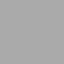

In [28]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(
    fold_f1.interpolators['gx'].propertyname,
    -2000,
    name=fold_f1.interpolators['gx'].propertyname+"_3",
    interactive=False,
    lv=lv,
    draw=False,
#     region="r1"
)
mesh.lv_plot_isosurface(
    fold_f1.interpolators['gx'].propertyname,
    1000,
    name=fold_f1.interpolators['gx'].propertyname+"_2",
    interactive=False,
    lv=lv,
    draw=False,
#     region="r1"
)
mesh.lv_plot_isosurface(
    fold_f1.interpolators['gx'].propertyname,
    0,
    name=fold_f1.interpolators['gx'].propertyname+"_1",
    interactive=False,
    lv=lv,
    draw=False,
#     region="r1"
)
# print(s0)
xyz = s0.loc[:,['x','y','z']].as_matrix()
# s0g = strike_dip_vector(s0.loc[:,'Dip_Dir']-90,s0.loc[:,'Dip'])

s0_ori = lv.vectors('s0_ori')
s0_ori.vertices(xyz)
s0_ori.vectors(s0g)
s1_ori = lv.vectors('s1_ori')
s1_ori.vertices(fold_f1.interpolators['gx'].get_gradient_control()[:,:3])
s1_ori.vectors(fold_f1.interpolators['gx'].get_gradient_control()[:,3:])
# mesh.lv_plot_isosurface(
#     'REGION_FaultSegmentRegion1',
#     0,
#     name='Strati2',
#     interactive=False,
#     lv=lv,
#     draw=False,
# #     region="FaultSegmentRegion%i"%1
# )

#mesh.lv_plot_isosurface('strati',1,name='Strati1',interactive=False,lv=lv,draw=False)
#mesh.lv_plot_isosurface(segments[4].interpolators['gx'].propertyname,0,name='Strati2',interactive=False,lv=lv,draw=False)

# mesh.lv_plot_isosurface('strati',2,name='Strati2',interactive=False,lv=lv,draw=False)
lv.control.Panel()
lv.control.ObjectList()
    # lv.reload()
lv.control.show()#nterac


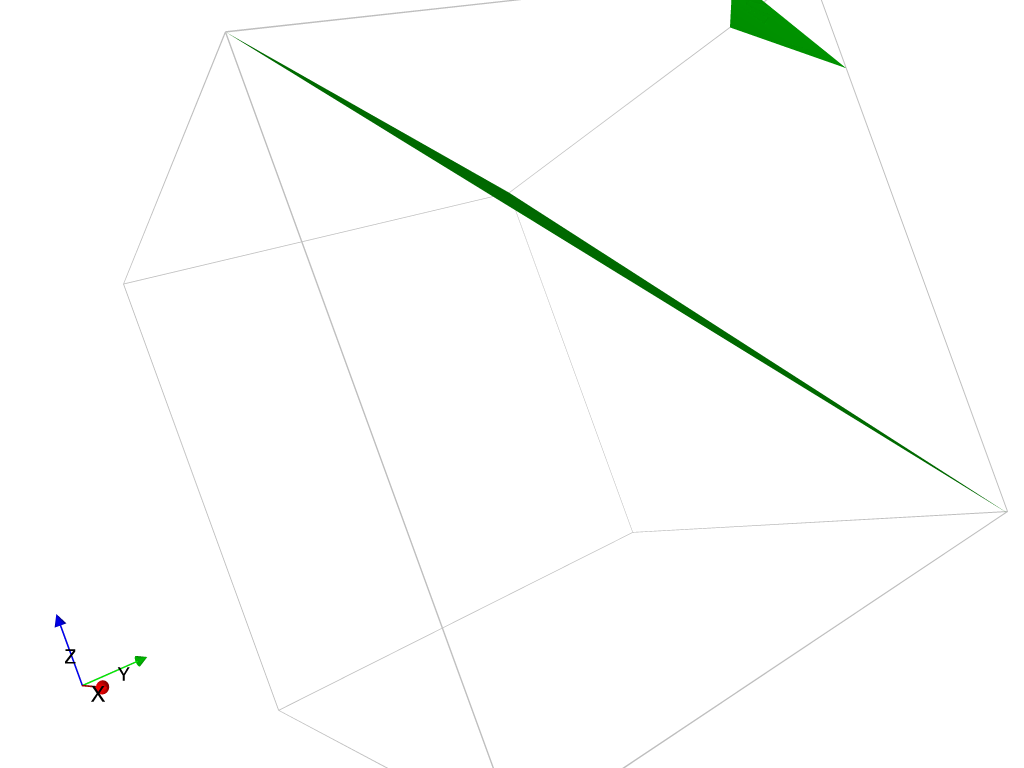

In [10]:
lv.rotation(-90,-60,20)
lv.display()

In [20]:
# from scipy.interpolate import Rbf
# far_tan = np.tan(np.deg2rad(far))
# rbf_fold_axis = Rbf(s1gy,np.zeros(s1gy.shape),np.zeros(s1gy.shape),far_tan,function='gaussian',epsilon=guess[0],smooth=.1)
# xi = np.linspace(-3000,2000,1000)
# plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_axis(xi,np.zeros(1000),np.zeros(1000)))))
# plt.plot(s1gy,far,'bo')
# plt.ylim(-90,90)
def fold_axis_rotation(x):
    r = np.zeros(len(x))
    r[:] = 180
    return r#0.#np.rad2deg(np.arctan(rbf_fold_axis(x,np.zeros(x.shape),np.zeros(x.shape))))

In [21]:
print(mesh.pca.transform([xyz[0,:]]))
print(mesh.minpc0)
print(mesh.minpc1)
print(mesh.minpc2)

print(mesh.maxpc0)
print(mesh.maxpc1)
print(mesh.maxpc2)

[[-4564.07162814  -545.70421641 -1342.76310219]]
-6389.700279400684
-4699.6708576750825
-2014.1446532893108
6389.700279401615
4699.6708576750825
2014.1446532893115


In [22]:
mesh.get_element(xyz[2,:])

(array([5184, 5522, 7495, 8592]), array([ True]))

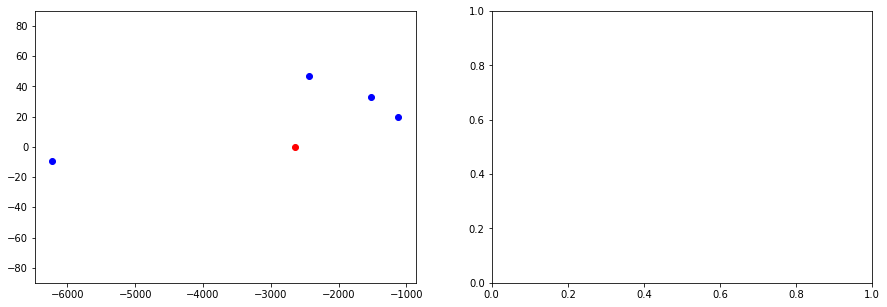

In [23]:
fold = FoldEvent(fold_f1,fold_axis_rotation,None)
axis = fold.get_fold_axis_orientation(xyz)
axis/=np.linalg.norm(axis,axis=1)[:,None]

s0g /= np.linalg.norm(s0g,axis=1)[:,None]#points[:,3:]
s1g = fold_f1.get_gx(xyz,grad=True)
s1g /= np.linalg.norm(s1g,axis=1)[:,None]
s1 = fold_f1.get_gx(xyz,grad=False)

projected_s0 = s0g #- np.einsum('ij,ij->i',axis,s0g)[:,None]*s0g
projected_s1 = s1g #- np.einsum('ij,ij->i',axis,s1g)[:,None]*s1g
#projected_s0/=np.linalg.norm(projected_s0,axis=1)[:,None]
#projected_s1/=np.linalg.norm(projected_s1,axis=1)[:,None]
r2 = np.einsum('ij,ij->i',projected_s1,projected_s0)#s1g,s0g)#
vv = np.cross(s1g,s0g,axisa=1,axisb=1)
ds = np.einsum('ik,ij->i',axis,vv)
flr = np.rad2deg(np.arcsin(r2))
# flr = np.where(ds>0, np.rad2deg(np.arcsin(r2)), (- np.rad2deg(np.arcsin(r2))))
# flr = np.where(flr<-90, (180.+flr),flr)
# flr = np.where(flr>90, -(180.-flr),flr)
#return flr

#flr = fold_f1.calculate_fold_limb_rotation(np.hstack([xyz,s0g]),axis=axis)
##quick figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
f1axis = points[points['Type']=='F1 Synform']
for i,f in f1axis.iterrows():
#     print(f['geometry'].xy)
    p = np.array([[f['geometry'].xy[0][0],f['geometry'].xy[1][0],0.],[f['geometry'].xy[0][0],f['geometry'].xy[1][0],0.]])
    f1axiss1 = fold_f1.get_gx(p,False)
ax[0].plot(f1axiss1[0],0,'ro')
ax[0].plot(s1,flr,'bo')
ax[0].set_ylim(-90,90)
#ax[0].ylim(-90,90)
svario = s_variogram(s1,flr)
svario.setup()
# guess = svario.find_wavelengths()
# ax[1].plot(svario.h,svario.var,'bo')
#ax[1].axvline(guess[1])
# guess = np.array(guess)
# guess[0] = 2500

In [15]:
print(xyz)
print(xmin,xmax,ymin,ymax)
print(fold_f1.interpolators['gx'].get_control_points()[:,:3])

[[ 320909.43584474 6600824.37112133       0.        ]
 [ 324812.04781663 6605223.07783541       0.        ]
 [ 320777.14391349 6609687.93051512       0.        ]
 [ 318098.23230567 6609952.51437762       0.        ]]
316755.4692034767 326154.81091882684 6598998.742470075 6611778.143028878
[]


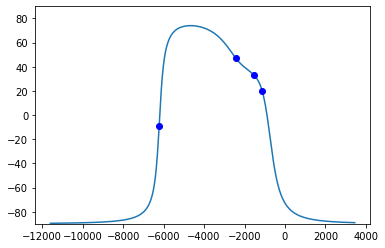

In [16]:
from scipy.interpolate import Rbf
flr_tan = np.tan(np.deg2rad(flr))
rbf_fold_limb = Rbf(
    s1,
    np.zeros(s1.shape),
    np.zeros(s1.shape),
    flr_tan,
    function='cubic',
    epsilon=2000,
    )
s11 = mesh.properties[fold_f1.interpolators['gx'].propertyname]
xi = np.linspace(np.min(s11),np.max(s11),1000)
plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_limb(xi,np.zeros(1000),np.zeros(1000)))))
plt.plot(s1,flr,'bo')
plt.ylim(-90,90)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(rbf_fold_limb(x,np.zeros(x.shape),np.zeros(x.shape))))

In [17]:
def fourier_series(c,wl,x):
    N = (len(c)-1) / 2
    N = 1
    wavelength_number = 1#len(wl)
    v = np.array(x.astype(float))
    v.fill(c[0])
    for w in range(wavelength_number):
        for i in range(1,N+1):
            v = v + c[(2*i-1)+2*N*w]*np.cos(2*np.pi/wl * i * (x)) + \
            c[(2*i)+2*N*w]*np.sin(2*np.pi/wl * i * (x))
    return v

In [18]:
import pymc
wl = pymc.Normal('wl',mu=12000,tau=1./(12000./3))

##set up priors for the coefficients
l = []
mu_ = 0.
i=0
t = 3. / 5.** 2
l.append(pymc.Normal("l_c_%i" % (i), mu=mu_, tau = t))
i+=1
for x in range(1):
    for _ in range(2*1):
        t = 1. / 5.**2
        mu_ = 0
        l.append(pymc.Normal("l_c_%i" % (i), mu=mu_, tau = t))
        i+=1
l_c = pymc.Container(l)
@pymc.stochastic(observed=False)
def sigma(value=1):
    return -np.log(abs(value))
@pymc.deterministic
def y_model(l_c=l_c,wl=wl,x=s1):
    return fourier_series(l_c,wl,x)


y = pymc.Normal('y', mu=y_model, tau=1. / sigma ** 2, observed=True, \
value=np.tan(np.deg2rad(flr)))
# package the full model in a dictionary
model1 = dict(y=y,l_c=l_c,wl=wl,x=s1, sigma=sigma)

# @pymc.deterministic
# def y_model_interlimb_limb(l_c=l_c,wl=wl):
#     x = np.linspace(-np.max(wl),np.max(wl))
#     v = np.rad2deg(np.arctan(fourier_series(l_c,wl,x)))
#     return np.max(v)-np.min(v)
# y_interlimb_limb = pymc.Normal('y_interlimb_limb',mu=y_model_interlimb_limb,value=140,
# tau = 1. / 30**2 )
# model1.update({'y_interlimb_limb':y_interlimb_limb})

# @pymc.deterministic
# def limb_vergence_values(l_c=L_C,l_wl=l_wl,y=np.array(self.vergence_limb)[:,0]):
#     return np.sign(fourier_series(l_c,l_wl,y))
# @pymc.stochastic(observed=True)
# def limb_vergence(value=np.array(self.vergence_limb)[:,1],mu=limb_vergence_values):
#     loglike = 0.
#     loglike+=pymc.distributions.normal_like((mu[value==1]),mu=1,tau=1.)
#     loglike+=pymc.distributions.normal_like((mu[value==-1]),mu=-1,tau=1.)
#     if loglike <= float(-1.7876931348623157e+308):
#         return float(-1.7876931348623157e+308)
#     return loglike 
# self.model_limb.update({'limb_vergence':limb_vergence}) 

S = pymc.MCMC(model1)

S.sample(iter=50000, burn=25000)

ModuleNotFoundError: No module named 'pymc'

In [ ]:
xi = np.linspace(np.min(s11),np.max(s11),100)
def get_fourier(i,xi):
    wl = S.trace('wl')[i]
    c=[]
    v = np.zeros(xi.shape)
    c.append(S.trace('l_c_0')[i])
    c.append(S.trace('l_c_1')[i])
    c.append(S.trace('l_c_2')[i])
    v[:] = np.rad2deg(np.arctan(fourier_series(c,wl,xi)))
    return v                                
def plot_fourier(i):
    wl = S.trace('wl')[i]
    c=[]
    c.append(S.trace('l_c_0')[i])
    c.append(S.trace('l_c_1')[i])
    c.append(S.trace('l_c_2')[i])
    plt.plot(xi,np.rad2deg(np.arctan(fourier_series(c,wl,xi))))
    plt.plot(s1,flr,'bo')
for i in range(100):
    plot_fourier(i)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(get_fourier(0,x)))#forbf_fold_limb(x,np.zeros(x.shape),np.zeros(x.shape))))

In [ ]:
#update the fold event to have a real fold_limb_rotation function
fold.fold_limb_rotation = fold_limb_rotation
const = DSIFoldConstraint(fold,mesh,shape='square') 
const.use_deformed_orientation_cnstrt(500.) 
const.use_fold_axis_cnstrt(25.) 
const.use_regularisation_cnstrt(100.) 
const.use_normalisation_cnstrt(1.0)

A, B, row, col = const.get_constraints()
deformed_orientation, fold_axis, dgz = fold.get_deformed_orientation(mesh.barycentre)
mesh.property_gradients['fold'] = deformed_orientation 
mesh.property_gradients['axis'] = fold_axis 
mesh.update_property('foldrot',fold_limb_rotation(mesh.properties[fold_f1.interpolators['gx'].propertyname]))

In [ ]:
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
stratigraphy.add_point(fold_f1.interpolators['gx'].get_gradient_control()[0,:3],0.)
stratigraphy.setup_interpolator(cg=False,cgw=0.)
stratigraphy.A.extend(A)
stratigraphy.row.extend(row)
stratigraphy.col.extend(col)
stratigraphy.B+=B
stratigraphy.solve_system(solver='chol',clear=True)
mesh.update_property('strati',stratigraphy.c)

In [ ]:
import lavavu
lv = lavavu.Viewer()
n_slice = 10
for s in np.linspace(np.min(s1),np.max(s1),n_slice):
#     print(s)
    mesh.lv_plot_isosurface(
        
        fold_f1.interpolators['gx'].propertyname,
        s,
        colour='red',
        name=fold_f1.interpolators['gx'].propertyname+'_%f'%s,
        interactive=False,
        lv=lv,
        draw=False,
    #     region="r1"
    )
xyz = s0.loc[:,['x','y','z']].as_matrix()
s0g = strike_dip_vector(s0.loc[:,'Dip_Dir']-90,s0.loc[:,'Dip'])
s0_ori = lv.vectors('s0_ori')
s0_ori.vertices(xyz)
s0_ori.vectors(s0g)
# strat = mesh.properties['strati']
# for s in np.linspace(np.min(strat),np.max(strat),n_slice):

#     mesh.lv_plot_isosurface(
#     'strati',
#     s,
#     name='Stratigraphy_%f'%s,
#     interactive=False,
#     lv=lv,
#     draw=False,
#     #     region="FaultSegmentRegion%i"%1
#     )


lv.control.Panel()
lv.control.ObjectList()
    # lv.reload()
lv.control.show()#nterac
# lv.interactive()

In [ ]:
mesh.plot_mesh('strati')